# Recommendations with IBM

In this project, we analyzed the interaction that users have with articles and built a recommender system to users using real data from the IBM Watson Studio platform. 

Types of recommendations implemented in this project:

* Knowledge Based Recommendations

* Collaborative Filtering Based Recommendations

* Content Based Recommendations

* Matrix Factorization


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>


In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  45993 non-null  float64
 1   title       45993 non-null  object 
 2   email       45976 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [4]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


In [5]:
# convert article_id to float type
df.article_id = pd.to_numeric(df.article_id)

In [6]:
df.loc[df.article_id == 1050,:].head()

,article_id,title,email
591,1050.0,"jupyter notebooks with scala, python, or r ker...",3a37a48d9e3b1f6035e058c7ae1c8090e82caa95
2446,1050.0,"jupyter notebooks with scala, python, or r ker...",958d0d2bc4760bdfa10abbf80a682b0593414c76
2803,1050.0,"jupyter notebooks with scala, python, or r ker...",6c8caac804860e9124f94f18ab201a67c43365d1
3069,1050.0,"jupyter notebooks with scala, python, or r ker...",388a67ec283df780739ba8d8c0ff656acbac2352
3480,1050.0,"jupyter notebooks with scala, python, or r ker...",8feb799552e6652ee3343c2053c5f84da4ab5a96


In [7]:
df_content.loc[df_content['article_id']==1050,:]

,doc_body,doc_description,doc_full_name,doc_status,article_id
1055,Homepage Follow Sign in / Sign up Homepage * H...,Once you get used to developing in a Notebook ...,"Jupyter Notebooks with Scala, Python, or R Ker...",Live,1050


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

In [8]:
# Create a user-article interaction dataframe
interaction_times = df.groupby('email').count()['title']

In [9]:
interaction_times.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: title, dtype: float64

Text(0.5, 1.0, 'Distribution of the number of interactions (outliers removed)')

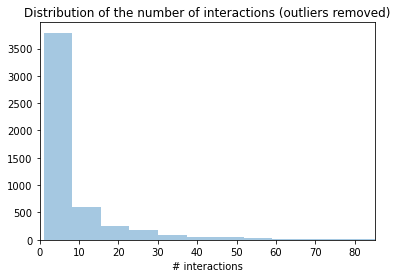

In [10]:
sns.distplot(interaction_times, kde=False)
plt.xlim((0,85))
plt.xlabel("# interactions")
plt.title('Distribution of the number of interactions (outliers removed)')

In [11]:
# Find and explore duplicate articles
df_content[df_content.article_id.duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [12]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], inplace=True)

In [13]:
df_content[df_content.article_id.duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id


In [14]:
# The number of user-article interactions
df.shape

(45993, 3)

In [15]:
# The number of unique articles that have at least one interaction
df.article_id.nunique()

714

In [16]:
# The number of unique articles on the IBM platform
df_content.shape

(1051, 5)

In [17]:
df.article_id.value_counts().head()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

There are 714 unique articles that have at least one interaction with a user. The number of unique articles on the IBM platform is 1051. 

The most viewed article in the dataset is Article '1429.0', which was viewed 937 times.

In [18]:
most_viewed_article_id = 1429.0
max_views = 937 

In [19]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []

    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1

        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this part, we make recommendations by finding the most popular articles based on the most interactions.

In [20]:
# return the n top articles ordered with most interactions 
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.title.value_counts().head(n).index.astype(str)
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.article_id.value_counts().head(n).index
    return top_articles # Return the top article ids

In [21]:
print(get_top_articles(10))
print(get_top_article_ids(10))

Index(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm',
       'healthcare python streaming application demo',
       'finding optimal locations of new store using decision optimization',
       'apache spark lab, part 1: basic concepts',
       'analyze energy consumption in buildings',
       'gosales transactions for logistic regression model'],
      dtype='object')
Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0,
              1162.0, 1304.0],
             dtype='float64')


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

The Rank-Based Recommendations we bulit in Part II will recommend the same articles to every user.  To make personalized recommendations, in this part, we will build collaborative filtering recommendation systems based on the similarity between users. 

First, we will create a user-article interaction matrix. 

* Each user appears in each row once. Each article only shows up in one column.

* If a user has interacted with an article, then place a 1 where the user-row meets for that article-column. If a user has not interacted with an item, then place a zero where the user-row meets for that article-column.

In [22]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    new_df = df.drop(columns=['title'])
    new_df.drop_duplicates(inplace=True)
    new_df['count'] = 1
    user_item = new_df.pivot(index='user_id', columns='article_id', values='count')
    user_item = user_item.fillna(0)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [23]:
user_item.to_pickle('./user_item_matrix.p')

Then we need to find out an ordered list of the most similar users to a given user. Here we compute the similarity by taking the dot product of two users

In [24]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    '''
    # compute similarity of each user to the provided user
    similarity_dict = dict()
    for k in user_item.index:
        similarity_dict[k] = np.dot(user_item.loc[user_id],user_item.loc[k])
    # sort by similarity
    # create list of just the ids
    most_similar_users = sorted(similarity_dict.keys(), key=lambda k: similarity_dict[k], reverse = True)

    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [25]:
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


Now we have the function that provides the most similar users to each user, we need to find articles we can recommend. We defind functions that will return the article ids and names that have been seen by a user.

In [26]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''

    article_names = df.loc[df.article_id.isin(article_ids),'title'].unique()
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''

    article_ids = user_item.loc[user_id][user_item.loc[user_id]==1].index
    article_names = get_article_names(article_ids)
    return article_ids, article_names # return the ids and names

We use all the functions we define above to recommend articles that the most similar users have seen but the given user have't been.

In [27]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''

    recs = []
    # Articles already seen
    seen_ids, _ = get_user_articles(user_id, user_item=user_item)
    # Find the most similar users
    most_similar_users = find_similar_users(user_id, user_item=user_item)
    # Loops through the users based on closeness to the input user_id
    for user in most_similar_users:
        ids, names = get_user_articles(user, user_item=user_item)
    
        #find ids that have not been read by user yet
        not_seen = list(set(ids) - set(seen_ids) - set(recs))
        
        #add to recs
        recs.extend(not_seen)
        if len(recs)>=m :
            break #when we have found enough articles
    return recs[:m] # return your recommendations for this user_id    

In [28]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array(['got zip code data? prep it for analytics. – ibm watson data lab – medium',
       'timeseries data analysis of iot events by using jupyter notebook',
       'fertility rate by country in total births per woman',
       'shaping data with ibm data refinery',
       'this week in data science (april 18, 2017)',
       'higher-order logistic regression for large datasets',
       'data tidying in data science experience',
       'data science platforms are on the rise and ibm is leading the way',
       'from scikit-learn model to cloud with wml client',
       'from spark ml model to online scoring with scala'], dtype=object)

Finally, we refine our model to inprove the consistency of the user_user_recs function from above.
* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.

* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. 

In [29]:
# sumarise the number of interaction of each user
num_interact_df = df.user_id.value_counts().to_frame('num_interactions')

In [30]:
def get_top_sorted_users(user_id, df=df, user_item=user_item, num_interact_df = num_interact_df):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    num_interact_df - dataframe of the number of interactions of each user
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    similarity_df = user_item.dot(user_item.loc[user_id])
    # get a sorted user similarity dataframe
    similarity_df = similarity_df.sort_values(ascending=False).\
                    drop(user_id).to_frame(name='similarity').reset_index() # drop the row of the given user
    
    # add a column of num_interactions to the similarity dataframe
    neighbors_df = similarity_df.merge(num_interact_df, left_on='user_id', right_index=True).\
                    rename(columns={'user_id':'neighbor_id'})
    
    # sort the neighbos by similarity and num_interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity','num_interactions'], ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string

In [31]:
def helper(df):
    i = 0
    while i < df.shape[0]:
        neighbor_id = df.loc[i,'neighbor_id']
        i += 1
        yield neighbor_id

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # get top 400 articles (their ids), if outside of top 400 we dont want to recommend
    all_articles_sorted = get_top_article_ids(400)
    recs = []
    
    # a list of article ids which have already been seen by the given user
    seen_ids, _ = get_user_articles(user_id)
    
    # get the sorted neighbors list
    neighbors_df = get_top_sorted_users(user_id, df=df, user_item=user_item, num_interact_df = num_interact_df)
    for neighbor_id in helper(df=neighbors_df):
        to_be_rec_ids, _ = get_user_articles(neighbor_id)
        unseen_ids = set(to_be_rec_ids)-set(seen_ids) - set(recs)
        not_seen_sorted = list(set(all_articles_sorted) & set(unseen_ids))
        recs.extend(not_seen_sorted)
        if len(recs) >=m:
            break
    recs = recs[:m]
    rec_names = get_article_names(recs)
    return recs, rec_names

In [32]:
# Quick spot check -  just use it to test  functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[903.0, 1160.0, 1162.0, 1165.0, 528.0, 1427.0, 1172.0, 1429.0, 1430.0, 1431.0]

The top 10 recommendations for user 20 are the following article names:
['using pixiedust for fast, flexible, and easier data analysis and experimentation'
 'use deep learning for image classification'
 'analyze energy consumption in buildings'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'apache spark lab, part 3: machine learning' 'analyze precipitation data'
 'analyze accident reports on amazon emr spark'
 '10 tips on using jupyter notebook'
 'an attempt to understand boosting algorithm(s)']


If we were given a new user, as new user haven't interacted with any article, we would use the get_top_article_ids() function to make recommendations.

In [33]:
new_user = 0.0

# recommendations for this new user '0.0'
new_user_recs = get_top_article_ids(10)
new_user_recs

Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0,
              1162.0, 1304.0],
             dtype='float64')

### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations </a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term. In this part, we consider content to be the the doc_full_names.


In [34]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yanhans/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yanhans/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
# Create a list of stopwords
stopwords = stopwords.words('english')
def tokenization_and_stemming(text):
    '''
    INPUT
    text - string
    OUTPUT
    clean_tokens - a list of words
    This function processes the input using the following steps :
    1. Remove punctuation characters and numbers
    2. Tokenize text into list
    3. Stem, normalize and strip each word
    4. Remove stop words
    '''
    # Remove punctuation characters and numbers
    text = re.sub(r"[^a-zA-Z]", " ", text)
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Create a instance of stem class
    stemmer = SnowballStemmer("english")
    
    clean_tokens = []
    for word in tokens:
        clean_tok = stemmer.stem(word).lower().strip()
        if clean_tok not in stopwords:
            clean_tokens.append(clean_tok)

    return clean_tokens

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
def get_article_similarity(df = df_content):
    
    # Use the doc_full_name fill the missing doc_description
    new_df_content = df.copy()
    new_df_content.loc[df['doc_description'].isna(), 'doc_description']\
    = new_df_content.loc[df['doc_description'].isna(), 'doc_full_name']
    doc_description = new_df_content["doc_description"].values
    
    # Create a TF-idf vectorizer
    tfidf_model = TfidfVectorizer(
    max_df=0.99, # max_df : maximum document frequency for the given word
    max_features=1000, # max_features: maximum number of words
    min_df=0.01, # min_df : minimum document frequency for the given word
    use_idf=True, # use_idf: if not true, we only calculate tf
    tokenizer=tokenization_and_stemming,
    ngram_range=(1,1)) # ngram_range: (min, max), eg. (1, 2) including 1-gram, 2-gram
    
    # Fit the TfidfVectorizer to our data
    tfidf_matrix = tfidf_model.fit_transform(doc_description)
    print("In total, there are {} reviews and {} terms.".format(
    str(tfidf_matrix.shape[0]), str(tfidf_matrix.shape[1])))
    
    # Calculate the cosine similarity between doc_description
    tfidf_array = tfidf_matrix.toarray()

    article_similarity = cosine_similarity(tfidf_matrix)
    return article_similarity, new_df_content

In [37]:
article_similarity,new_df_content = get_article_similarity(df_content)

In total, there are 1051 reviews and 321 terms.


In [38]:
# Take a look at the similarity matrix
article_similarity[0]

array([1.        , 0.        , 0.        , ..., 0.        , 0.02667237,
       0.02955821])

In [39]:
# Given an article_id, we want to find the most similarity articles based on the doc_description
new_df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [40]:
def find_similar_articles(article_id, df_content=new_df_content, threshold=0.3, article_similarity=article_similarity):
    # find the row of each article id
    try:
        # find the row number of the given article_id
        article_idx = np.where(df_content["article_id"] == article_id)[0][0]

        # find the most similar article indices
        similar_article_idxs = np.where(article_similarity[article_idx] >= threshold*np.max(article_similarity[article_idx]))[0]

        # find similar articles from df_content
        similar_articles = df_content.iloc[similar_article_idxs]["article_id"].tolist()
        similar_articles.remove(article_id)
        return similar_articles
    except:
        return []

In [41]:
new_df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [42]:
# see the most similar articles to article 1000
find_similar_articles(1000)

[7, 296, 788, 860, 1040]

In [43]:
def make_content_recs(_id, user_id=True, m=10, df=df, threshold = 0.3):
    '''
    INPUT:
        _id - Either user_id or article_id
        user_id - parameter to indicate whether _id is user_id or article_id
        m - number of recommendations
        df - dataframe which has dot product of articles to itself(tranposed)
    
    OUTPUT:
        list - m recommendation i.e. articles
    '''
    
    recs = set()
    
    # find the top m articles
    top_m_articles = get_top_article_ids(m)
    top_m_articles = list(map(lambda a: float(a), top_m_articles))
    
    if user_id:
        # Pull only the articles the user has interacted with
        seen_ids = df[df['user_id'] == _id].article_id.values
        
        seen_ids = set(seen_ids)
        for seen_id in seen_ids:
            
            similar_article_id_list = find_similar_articles(seen_id, threshold=threshold)
            if similar_article_id_list is None:
                continue
            recs = recs | set(similar_article_id_list)

        recs.difference_update(seen_ids)
        recs = list(recs)
        
    else:
        # if given an article id instead
        recs = find_similar_articles(_id, threshold=threshold)
        if recs is None:
            # There is no similar ariticle found, return the popular articles
            return top_m_articles
    
    # If there are less than 10 similar articles, recommend the top 10 popular
    if len(recs) < m:
        recs.extend(top_m_articles)
        recs = list(set(recs))
    return recs[:m]

In [44]:
make_content_recs(3)

[0, 2, 4, 1030, 9, 522, 523, 13, 1038, 14]

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, I will choose a machine learning approach to making recommendations. 



In [45]:
# Load the user_item matrix
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [46]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
user_item_matrix.shape

(5149, 714)

In [48]:
# Perform Singular Value Decomposition(SVD) on the User-Item Matrix
u, s, vt = np.linalg.svd(user_item_matrix)
print(u.shape, s.shape, vt.shape)

(5149, 5149) (714,) (714, 714)


In [49]:
print("The shape of df", df.shape)
df.head()

The shape of df (45993, 3)


,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


There is no missing value in this user_item matrix.

*Accuracy improves as we increase the number of latent features.*

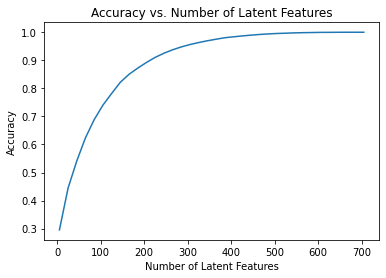

In [50]:
num_latent_feats = np.arange(5,714,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

As we can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.

From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  



In [51]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # create user-item matrices of the training dataframe and testing dataframe
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # find the common user ids in test and train set
    train_idx = set(user_item_train.index)
    test_idx = set(user_item_test.index)
    common_idx = train_idx.intersection(test_idx)
    
    # find the common article ids in test and train set
    train_cols = set(user_item_train.columns)
    test_cols = set(user_item_test.columns)
    common_cols = train_cols.intersection(test_cols)
    
    user_item_test = user_item_test.loc[common_idx, common_cols]
    
    # get the test user ids 
    test_idx = user_item_test.index
    
    # get the test article ids
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [52]:
print("The shape of the testing user item matrix is :",user_item_test.shape)

The shape of the testing user item matrix is : (20, 574)


In [53]:
print("The shape of the testing user item matrix is :",user_item_train.shape)

The shape of the testing user item matrix is : (4487, 714)


Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [54]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
print(u_train.shape, s_train.shape, vt_train.shape)

(4487, 4487) (714,) (714, 714)


In [55]:
# get the index of common users in train user-item matrix and test user-item matrix 
train_common_idx = user_item_train.index.isin(test_idx)
# get the common columns in train user-item matrix and test user-item matrix 
train_common_col = user_item_train.columns.isin(test_arts)

In [56]:
# get the u vt matrices for predictions
u_test = u_train[train_common_idx, :]
vt_test = vt_train[:, train_common_col]

In [57]:
u_test.shape, vt_test.shape

((20, 4487), (714, 574))

In [58]:
sum_train_errs = []
sum_test_errs = []


#make predictions based on train_set SVD for the overlapping 20 users that are also in the test set
#compare these predictions with the actual test matrix to get errer
num_latent_features = np.arange(5,714,5)
for k in num_latent_features: 
    
    # restructure with k latent features
    u_train_k, s_train_k, vt_train_k = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k, :]
    u_test_k, vt_test_k = u_test[:, :k], vt_test[:k,:]
    
    # make predictions by taking the dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_k, s_train_k), vt_train_k))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_k, s_train_k), vt_test_k))
                
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test, user_item_test_preds)
    
    # total errors and keep track of them
    train_err = np.sum(np.sum(np.abs(diffs_train))) 
    sum_train_errs.append(train_err)
    
    test_err = np.sum(np.sum(np.abs(diffs_test))) #first sum cols then rows
    sum_test_errs.append(test_err)

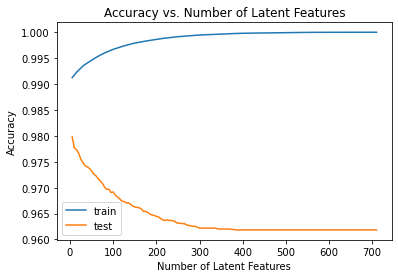

In [59]:
#plot errors
plt.plot(num_latent_features, 1 - np.array(sum_train_errs)/(user_item_train.shape[0]*user_item_train.shape[1]), label='train');
plt.plot(num_latent_features, 1 - np.array(sum_test_errs)/(user_item_test.shape[0]*user_item_test.shape[1]), label='test');
plt.legend(loc='best')
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.show();

Wow, it seems that 5 latent features work quite similar to 710 latent features. 

For new users, using knowledge-based or rank-based recommendation is a good way to go. For new articles, we can use content-based recommendation. And also, the matrix factorization can perform well.

In [60]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0